In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [12]:
dg = xr.open_dataset('outer_avg.nc')
dg

<xarray.Dataset>
Dimensions:         (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                     xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                     eta_psi: 316, xi_psi: 271, ocean_time: 30)
Coordinates:
  * s_rho           (s_rho) float64 -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w             (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 1994-02-01 ... 1994-03-02
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/128)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    rain            (ocean_time, eta_rho, xi_rho) float32 ...
    swrad           (ocean_time, eta_rho, xi_rho) float32 ...
    sustr           (ocean_time, eta_u, xi_u) float32 ...
    svstr           (ocean_time, eta_v, xi_v) float32 ...
    bustr           (ocean_time, eta_u, xi_u) float32 ...
    bvstr           (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/34)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [13]:

lat_rho = dg["lat_rho"]
lon_rho = dg["lon_rho"]
lat_u = dg["lat_u"]
lon_u = dg["lon_u"]
lat_v = dg["lat_v"]
lon_v = dg["lon_v"]
pm = dg["pm"]
pn = dg["pn"]
h = dg["h"]

area=np.divide(1,pm*pn)

In [14]:
land_mask = np.isnan(dg.temp.isel(ocean_time=0, s_rho=-1))

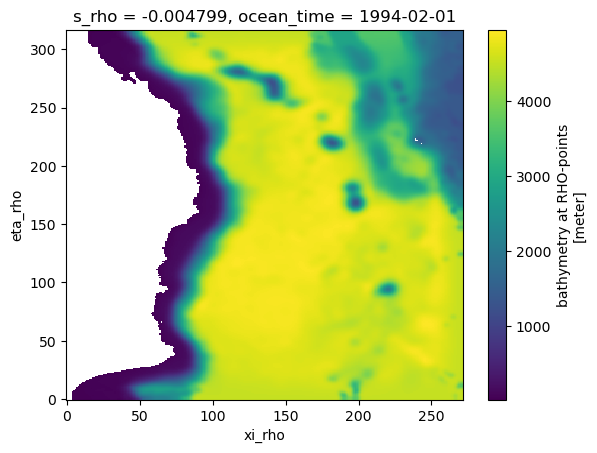

In [15]:
# dg.temp.isel(ocean_time=0, s_rho=-1).where(~land_mask).where(h <= 200).isel(eta_rho=slice(30, -50), xi_rho=slice(30, -170)).plot(y='lat_rho', x='lon_rho')
h = h.where(~land_mask)
h.plot()

In [16]:
# Fill in land with zeros:
h = h.fillna(0)
# h.where(h<=200).plot()


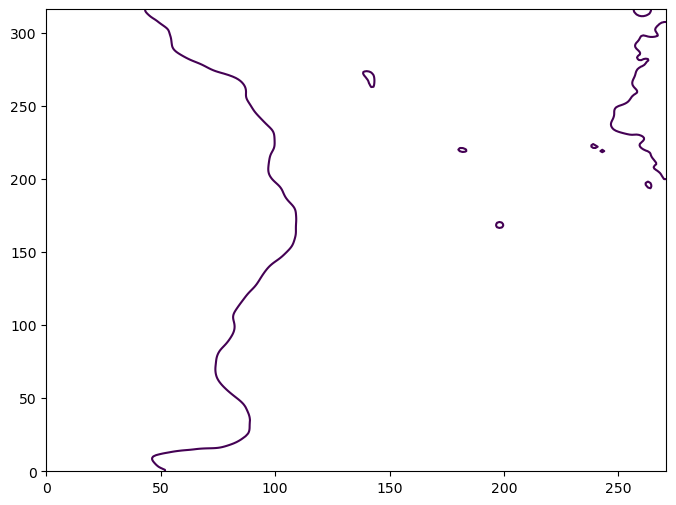

In [18]:
contour_depth = 1500.

grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

fig = plt.figure(figsize = (8, 6))
count = 164 # contour 87 for 2000m isobath, 165 for 1500m
x_contour = []
y_contour = []


# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())

        count += 1
        if count ==  212:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

In [19]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)


In [20]:
# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)


In [21]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [22]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

In [23]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho


In [24]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
    lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]

In [25]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

IndexError: index 0 is out of bounds for axis 0 with size 0